In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
# Importing neccessary libraries
import matplotlib.pyplot as plt
import numpy
import pandas
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# 1. Reading the dataset

In [ ]:
ClothingPrice = pandas.read_csv('clothes_price_prediction_data.csv', encoding="latin")

print("Deleting duplicates"
      "\nShape Before: ", ClothingPrice.shape)
ClothingPrice = ClothingPrice.drop_duplicates()
print("Shape After: ", ClothingPrice.shape)

print("\nFirst 15 rows of data: ")
ClothingPrice.head(15)

Deleting duplicates
Shape Before:  (1000, 6)
Shape After:  (1000, 6)

First 15 rows of data: 


,Brand,Category,Color,Size,Material,Price
0,New Balance,Dress,White,XS,Nylon,182
1,New Balance,Jeans,Black,XS,Silk,57
2,Under Armour,Dress,Red,M,Wool,127
3,Nike,Shoes,Green,M,Cotton,77
4,Adidas,Sweater,White,M,Nylon,113
5,Reebok,Jacket,Red,XL,Nylon,19
6,Puma,Jacket,Red,XXL,Polyester,31
7,Adidas,Dress,Red,XS,Denim,46
8,Reebok,Dress,Black,S,Wool,97
9,Adidas,Jeans,Yellow,L,Wool,80


Notes:

*   File has 1000 rows of data
*   File has 6 Attributes



# 2. Problem Statement Definition
- To generate a data model that will predict the price of a piece of clothing

# 3. Target Variable Identification
Target variable: Price
Predictors: Brand, Category, Color, Size and Material

# 4. Visualising the Distribution of Target Variable

<Axes: >

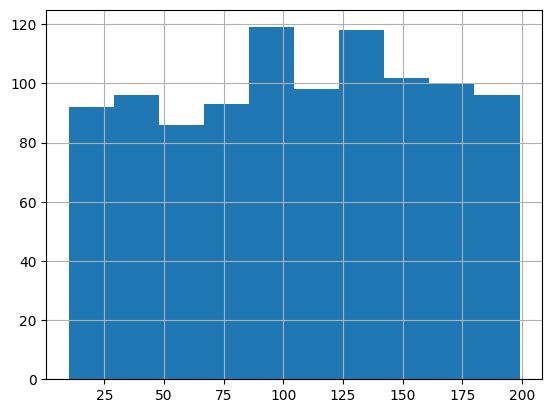

In [ ]:
ClothingPrice["Price"].hist()

Notes:
- The shape is not a bell curve, but I believe the reason for this is likely due to there being a similar amount of data in each clothing category

# 5. Data Exploration at Basic Level

In [ ]:
ClothingPrice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Brand     1000 non-null   object
 1   Category  1000 non-null   object
 2   Color     1000 non-null   object
 3   Size      1000 non-null   object
 4   Material  1000 non-null   object
 5   Price     1000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


In [ ]:
ClothingPrice.describe(include="all")

,Brand,Category,Color,Size,Material,Price
count,1000,1000,1000,1000,1000,1000.000000
unique,6,6,6,6,6,NaN
top,Under Armour,Jacket,Yellow,XS,Polyester,NaN
freq,179,191,173,196,175,NaN
mean,NaN,NaN,NaN,NaN,NaN,106.289000
std,NaN,NaN,NaN,NaN,NaN,53.695444
min,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,NaN,NaN,NaN,NaN,59.750000
50%,NaN,NaN,NaN,NaN,NaN,108.000000
75%,NaN,NaN,NaN,NaN,NaN,150.000000


In [ ]:
ClothingPrice.nunique()

Brand         6
Category      6
Color         6
Size          6
Material      6
Price       190
dtype: int64

Notes:
- Brand - Categorical, Selected
- Category - Categorical, Selected
- Color - Categorical, Selected
- Size - Categorical, Selected
- Material - Categorical, Selected
- Price - Continuous, Selected, Target Variable

In [ ]:
dataPredictors = ["Brand", "Category", "Color", "Size", "Material"]

# 6. Identifying and Rejecting Useless Columns
No need to do this as there is no qualitative data

# 7. Visual Exploratory Data Analysis of Data
(With histogram and bar charts)

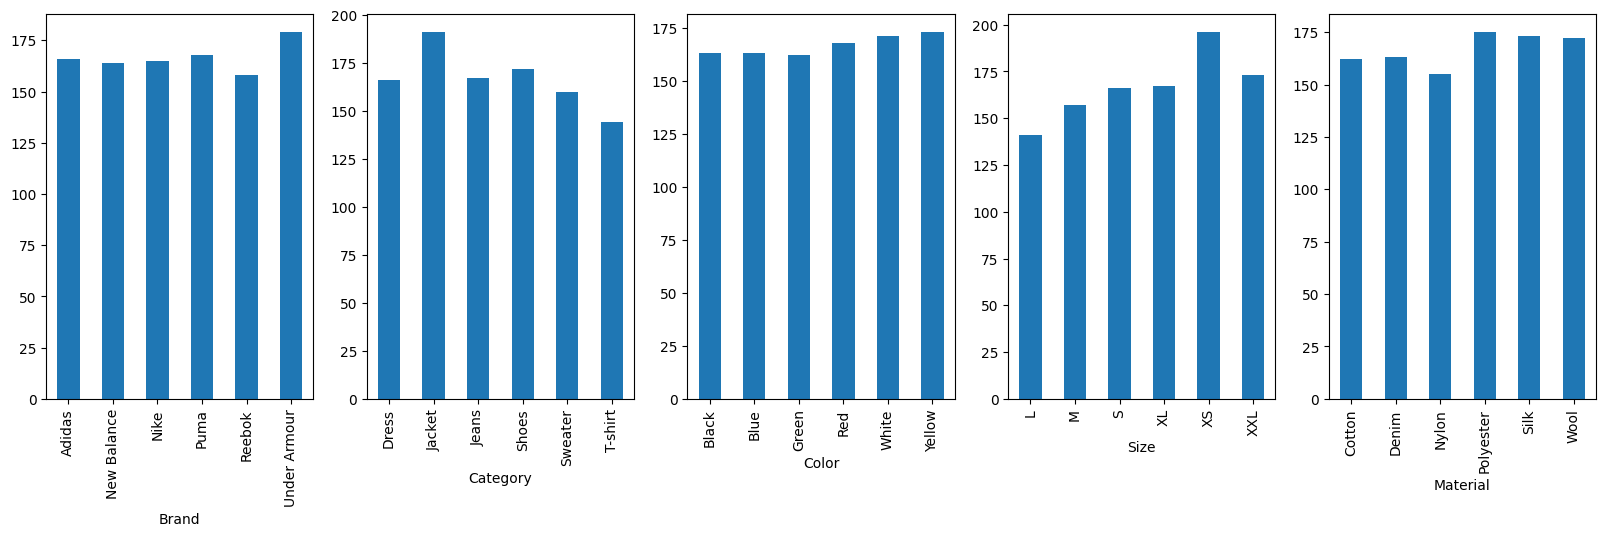

In [ ]:
def plotGraphs(dataInput, categories: list):
  fig, subPlot = plt.subplots(nrows=1, ncols=len(categories), figsize=(20,5))

  for category, index in zip(categories, range(len(categories))):
    dataInput.groupby(category).size().plot(kind='bar',ax=subPlot[index])

plotGraphs(ClothingPrice, dataPredictors)

# 8. Feature Selection Based on Data Distribution

<Axes: >

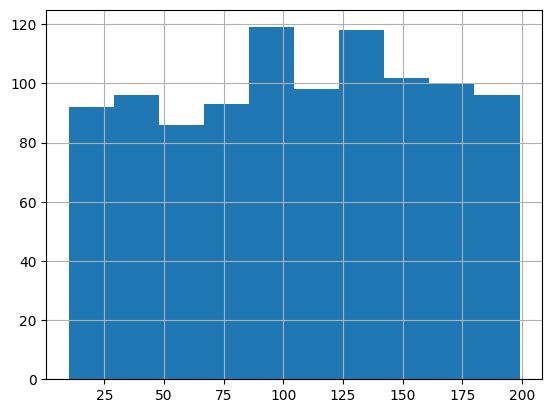

In [ ]:
ClothingPrice["Price"].hist()

In [ ]:
ClothingPrice.isnull().sum()

Brand       0
Category    0
Color       0
Size        0
Material    0
Price       0
dtype: int64

Notes:
- There is only one continuous category, Price
- Price - Selected
- No missing values

# 9. Removal of Outliers and Missing Values
There is no need to remove any outliers as each piece of data has a noticable presence and matches the range of other data.

# 10. Visual and Statistic Correlation Analysis for Selection of Best Features

Categorical VS Continuous: Box Plots

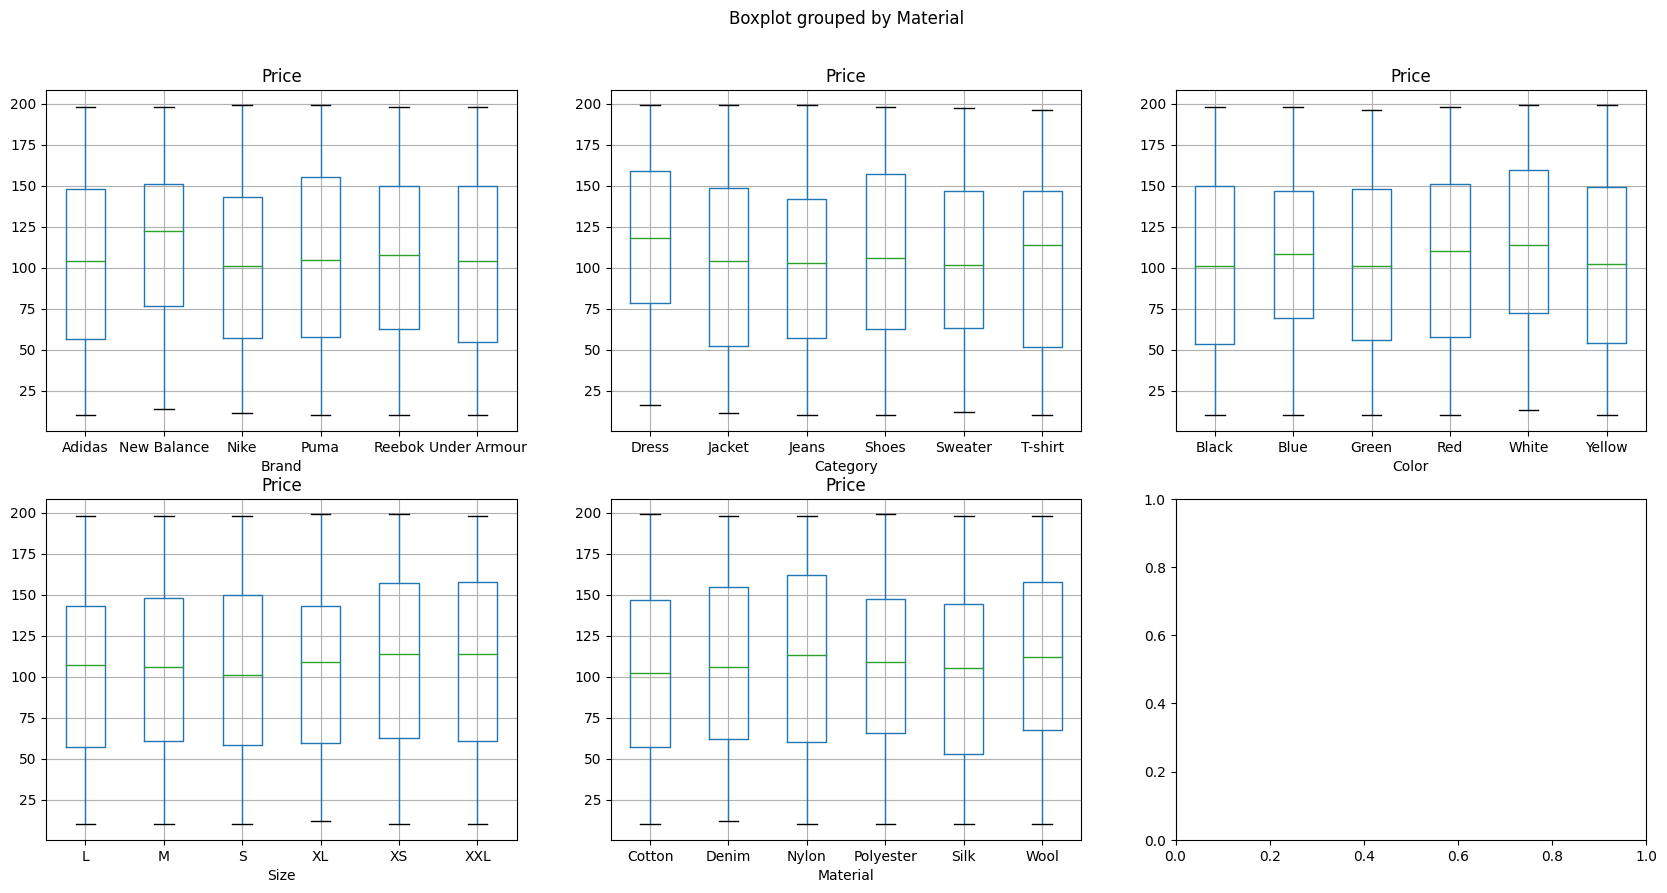

In [ ]:
def createBoxPlots(dataInput, categories):
  rows = math.ceil(len(categories) / 3)
  fig, subPlot = plt.subplots(nrows=rows, ncols=3, figsize=(20, (5 * rows)))

  for category, index in zip(categories, range(len(categories))):
    row = math.floor(index / 3)
    index -= (3 * row)
    dataInput.boxplot(column="Price", by=category, vert=True, ax=subPlot[row, index])

createBoxPlots(ClothingPrice, dataPredictors)

In [ ]:
def FunctionAnova(dataInput, TargetVariable, predictors):
  from scipy.stats import f_oneway
  SelectedPredictors = []
  print('ANOVA Results\n')
  for predictor in predictors:
    CategoryGroupLists = dataInput.groupby(predictor)[TargetVariable].apply(list)
    AnovaResults = f_oneway(*CategoryGroupLists)
    if (AnovaResults[1] < 0.05):
      print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
      SelectedPredictors.append(predictor)
    else:
      print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
  return(SelectedPredictors)

FunctionAnova(ClothingPrice, "Price", dataPredictors)

##### ANOVA Results ##### 

Brand is NOT correlated with Price | P-Value: 0.2601099878167752
Category is NOT correlated with Price | P-Value: 0.22576473150531826
Color is NOT correlated with Price | P-Value: 0.4617893742587683
Size is NOT correlated with Price | P-Value: 0.7098835429591747
Material is NOT correlated with Price | P-Value: 0.7365826899195708


[]

Boxes are not in exactly the same line for each category, therefore the categorical data slightly correlates to the continuous data.

---

Note: As instructed by the lecturer, correlation between values is not required to continue to further steps.

# 11. Data Conversion to Numeric Values for Machine Learning/Predictive Analysis

Original Data:

In [ ]:
ClothingPrice.head()

,Brand,Category,Color,Size,Material,Price
0,New Balance,Dress,White,XS,Nylon,182
1,New Balance,Jeans,Black,XS,Silk,57
2,Under Armour,Dress,Red,M,Wool,127
3,Nike,Shoes,Green,M,Cotton,77
4,Adidas,Sweater,White,M,Nylon,113


Converted Data:

In [ ]:
ClothingPriceNumeric = ClothingPrice.copy()
labelEncoder = LabelEncoder()

changes = [{}, {}, {}, {}, {}]

for category in dataPredictors:
    ClothingPriceNumeric[category] = labelEncoder.fit_transform(ClothingPriceNumeric[category])
    for encoder_class in labelEncoder.classes_:
      changes[dataPredictors.index(category)].update({encoder_class:labelEncoder.transform([encoder_class])[0]})

print("Listing changes")
for dictionary in changes:
  print(dataPredictors[changes.index(dictionary)])
  print(dictionary, "\n")

ClothingPriceNumeric.head()

Listing changes
Brand
{'Adidas': 0, 'New Balance': 1, 'Nike': 2, 'Puma': 3, 'Reebok': 4, 'Under Armour': 5} 

Category
{'Dress': 0, 'Jacket': 1, 'Jeans': 2, 'Shoes': 3, 'Sweater': 4, 'T-shirt': 5} 

Color
{'Black': 0, 'Blue': 1, 'Green': 2, 'Red': 3, 'White': 4, 'Yellow': 5} 

Size
{'L': 0, 'M': 1, 'S': 2, 'XL': 3, 'XS': 4, 'XXL': 5} 

Material
{'Cotton': 0, 'Denim': 1, 'Nylon': 2, 'Polyester': 3, 'Silk': 4, 'Wool': 5} 



,Brand,Category,Color,Size,Material,Price
0,1,0,4,4,2,182
1,1,2,0,4,4,57
2,5,0,3,1,5,127
3,2,3,2,1,0,77
4,0,4,4,1,2,113


# 12. Training/Testing Sampling and K-fold Cross Validation

In [ ]:
predictors=ClothingPriceNumeric[dataPredictors].values
target=ClothingPriceNumeric["Price"].values

predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.3, random_state=428)

# 13. Investigating Multiple Regression Algorithms

Normalisation

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scalerFit = scaler.fit(predictors)
predictors = scalerFit.transform(predictors)
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.3, random_state=1000)

Linear Regression

In [ ]:
def runAlgorithm(chosenAlgorithm):
  print(chosenAlgorithm)
  model = chosenAlgorithm.fit(predictors_train, target_train)
  prediction = model.predict(predictors_test)
  print("Prediction for [1, 2, 3, 4, 5]: ", model.predict([[1, 2, 3, 4, 5]])) # Remove
  print('R2 Value:', metrics.r2_score(target_train, model.predict(predictors_train)))

  testResults = pandas.DataFrame(data=predictors_test, columns=dataPredictors)
  testResults["Price"] = target_test
  testResults[("Predicted Price")] = numpy.round(prediction)
  print(testResults.head())

  testResults['APE'] = 100 * ((abs(testResults['Price'] - testResults['Predicted Price'])) / testResults['Price'])
  MAPE = numpy.mean(testResults['APE'])
  accuracy = 100 - MAPE
  medianAccuracy = 100 - (numpy.median(testResults["APE"]))
  print("Mean Accuracy = ", accuracy)
  print("Median Accuracy = ", medianAccuracy)

  def Accuracy_Score(original, predicted):
    MAPE = numpy.mean(100 * (numpy.abs(original - predicted) / original))
    return(100 - MAPE)

  customScoring = make_scorer(Accuracy_Score, greater_is_better = True)
  accuracyValues = cross_val_score(chosenAlgorithm, predictors, target, cv = 10, scoring = customScoring)
  print("10-fold Cross Accuracy Validation: ", accuracyValues)
  print(f"Final Accuracy: {round(accuracyValues.mean(), 2)}\n")

runAlgorithm(LinearRegression())

runAlgorithm(RandomForestRegressor(max_depth=2, n_estimators=400, criterion='friedman_mse'))

runAlgorithm(AdaBoostRegressor(n_estimators=1000, estimator=DecisionTreeRegressor(max_depth=3) , learning_rate=0.2))

runAlgorithm(XGBRegressor(max_depth=2, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree'))

LinearRegression()
Prediction for [1, 2, 3, 4, 5]:  [138.80811427]
R2 Value: 0.006116928258967369
   Brand  Category  Color  Size  Material  Price  Predicted Price
0    0.4       0.8    0.6   0.2       0.0    111            100.0
1    0.4       0.8    0.6   0.2       0.2    156            101.0
2    0.0       0.2    0.0   0.0       1.0     45            105.0
3    1.0       1.0    0.2   0.6       0.4    159             96.0
4    0.4       1.0    0.2   0.6       0.0    120             95.0
Mean Accuracy =  29.20730023926903
Median Accuracy =  65.47467278599353
10-fold Cross Accuracy Validation:  [ 14.50010712 -16.15473466 -20.57668045  13.09281756   3.37835864
  22.45952268  44.47706989  -1.11246404  -7.30294289   3.05268312]
Final Accuracy: 5.58

RandomForestRegressor(criterion='friedman_mse', max_depth=2, n_estimators=400)
Prediction for [1, 2, 3, 4, 5]:  [107.18339759]
R2 Value: 0.028262539060989522
   Brand  Category  Color  Size  Material  Price  Predicted Price
0    0.4       0.8 

Notes:
- Highest Accuracy is Linear Regression
- Highest Overall Accuracy is AdaBoost


# 14. Selection of the Best Model

I am selecting AdaBoost as it has the highest overall accuracy

# 15. Deployment of the Best Model in Production
Please refer to GUI python program

In [ ]:
# Note: sklearn must be version 1.4.2 to make this work with the GUI code
# import joblib

# chosenAlgorithm = AdaBoostRegressor(n_estimators=1000, estimator=DecisionTreeRegressor(max_depth=3) , learning_rate=0.2)
# model = chosenAlgorithm.fit(predictors_train, target_train)

# joblib.dump(model, "adaBoostModel.joblib")